Normal: 1551 images
Stroke: 950 images


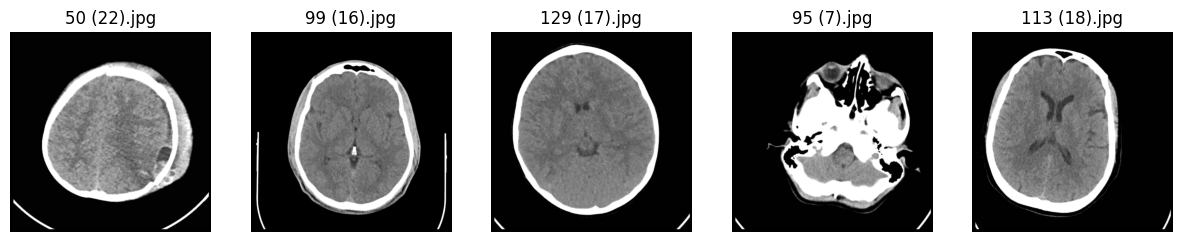

Example: 50 (22).jpg | Patient ID: 50, Slice #: 22


In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import re

# Dataset path
base_input_folder = "/kaggle/input/brain-data/Brain_Data_Organised"
classes = ["Normal", "Stroke"]

# Check class folders and image counts
for c in classes:
    class_path = os.path.join(base_input_folder, c)
    if not os.path.isdir(class_path):
        raise ValueError(f"Folder not found: {class_path}")
    images = [f for f in os.listdir(class_path) if f.lower().endswith(".jpg")]
    print(f"{c}: {len(images)} images")

# Preview few images
sample_images = [f for f in os.listdir(os.path.join(base_input_folder, classes[0])) if f.lower().endswith(".jpg")][:5]
plt.figure(figsize=(15,3))
for i, img_file in enumerate(sample_images):
    img = Image.open(os.path.join(base_input_folder, classes[0], img_file)).convert('L')
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img_file)
    plt.axis('off')
plt.show()

# Check patient ID and slice parsing
def parse_filename(filename):
    match = re.match(r"(\d+)\s*\((\d+)\)", os.path.splitext(filename)[0])
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

patient_id, slice_num = parse_filename(sample_images[0])
print(f"Example: {sample_images[0]} | Patient ID: {patient_id}, Slice #: {slice_num}")


### Grouping Slices per Patient

In [2]:
import os
import re

# Parse filename to get patient ID and slice number
def parse_filename(filename):
    match = re.match(r"(\d+)\s*\((\d+)\)", os.path.splitext(filename)[0])
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

# Group slices for each patient
def group_subjects(class_path):
    subjects = {}
    for file in os.listdir(class_path):
        if file.lower().endswith(".jpg"):
            pid, slice_num = parse_filename(file)
            if pid is not None:
                subjects.setdefault(pid, []).append((slice_num, file))
    return subjects

# Apply to all classes
base_input_folder = "/kaggle/input/brain-data/Brain_Data_Organised"
classes = ["Normal", "Stroke"]
all_subjects = {}

for c in classes:
    class_path = os.path.join(base_input_folder, c)
    all_subjects[c] = group_subjects(class_path)
    print(f"{c}: {len(all_subjects[c])} patients grouped")
    
# Example: check slices of one patient
example_pid = list(all_subjects["Normal"].keys())[0]
example_slices = sorted(all_subjects["Normal"][example_pid], key=lambda x: x[0])
print(f"Patient {example_pid} slices:", [f[1] for f in example_slices[:5]])


Normal: 51 patients grouped
Stroke: 31 patients grouped
Patient 50 slices: ['50 (1).jpg', '50 (2).jpg', '50 (3).jpg', '50 (4).jpg', '50 (5).jpg']


### Convert slices → 3D NIfTI volumes

In [3]:
import os
import numpy as np
from PIL import Image
import nibabel as nib
from scipy.ndimage import zoom

# Base paths
base_input_folder = "/kaggle/input/brain-data/Brain_Data_Organised"
base_output_folder = "/kaggle/working/nifti_volumes"
os.makedirs(base_output_folder, exist_ok=True)

# Function to convert patient slices → 3D volume and save as NIfTI
def convert_to_nifti(subject_id, slices, class_path, output_class_path, voxel_spacing=(1.0,1.0,1.0)):
    slices.sort(key=lambda x: x[0])
    volume = [np.array(Image.open(os.path.join(class_path, f)).convert('L')) for _, f in slices]
    volume = np.stack(volume, axis=-1)
    
    # Resize to standard shape (optional)
    target_shape = (224, 224, volume.shape[2])
    factors = (target_shape[0]/volume.shape[0], target_shape[1]/volume.shape[1], target_shape[2]/volume.shape[2])
    volume = zoom(volume, factors, order=1)
    
    # Create NIfTI
    affine = np.eye(4)
    affine[0,0], affine[1,1], affine[2,2] = voxel_spacing
    nifti_img = nib.Nifti1Image(volume, affine)
    
    os.makedirs(output_class_path, exist_ok=True)
    output_path = os.path.join(output_class_path, f"patient_{subject_id}.nii.gz")
    nib.save(nifti_img, output_path)
    return output_path, volume.shape

# Convert all patients
classes = ["Normal", "Stroke"]
all_paths = {}

for c in classes:
    output_class_path = os.path.join(base_output_folder, c)
    all_paths[c] = []
    for pid, slices in all_subjects[c].items():
        nifti_path, shape = convert_to_nifti(pid, slices,
                                             os.path.join(base_input_folder, c),
                                             output_class_path)
        all_paths[c].append(nifti_path)
        print(f"Saved {nifti_path} | Shape: {shape}")


Saved /kaggle/working/nifti_volumes/Normal/patient_50.nii.gz | Shape: (224, 224, 26)
Saved /kaggle/working/nifti_volumes/Normal/patient_99.nii.gz | Shape: (224, 224, 29)
Saved /kaggle/working/nifti_volumes/Normal/patient_129.nii.gz | Shape: (224, 224, 30)
Saved /kaggle/working/nifti_volumes/Normal/patient_95.nii.gz | Shape: (224, 224, 29)
Saved /kaggle/working/nifti_volumes/Normal/patient_113.nii.gz | Shape: (224, 224, 28)
Saved /kaggle/working/nifti_volumes/Normal/patient_111.nii.gz | Shape: (224, 224, 33)
Saved /kaggle/working/nifti_volumes/Normal/patient_100.nii.gz | Shape: (224, 224, 30)
Saved /kaggle/working/nifti_volumes/Normal/patient_102.nii.gz | Shape: (224, 224, 31)
Saved /kaggle/working/nifti_volumes/Normal/patient_125.nii.gz | Shape: (224, 224, 40)
Saved /kaggle/working/nifti_volumes/Normal/patient_106.nii.gz | Shape: (224, 224, 29)
Saved /kaggle/working/nifti_volumes/Normal/patient_108.nii.gz | Shape: (224, 224, 29)
Saved /kaggle/working/nifti_volumes/Normal/patient_120.ni

### Skull-Stripping Using HD-BET

In [4]:
# Install HD-BET
!pip install git+https://github.com/MIC-DKFZ/HD-BET.git

import os
from glob import glob

input_base = "/kaggle/working/nifti_volumes"  # change if needed
output_base = "/kaggle/working/skullstripped"
os.makedirs(output_base, exist_ok=True)

# Dummy run to download weights
normal_files = glob(os.path.join(input_base, "Normal", "*.nii.gz"))
if normal_files:
    first_file = normal_files[0]
    !hd-bet -i "{first_file}" -o "{output_base}/dummy.nii.gz" -device cpu
else:
    print("No files found in Normal/. Skipping dummy run.")

# Process all files
for cls in ["Normal", "Stroke"]:
    in_dir = os.path.join(input_base, cls)
    out_dir = os.path.join(output_base, cls)
    os.makedirs(out_dir, exist_ok=True)

    nii_files = glob(os.path.join(in_dir, "*.nii.gz"))
    if not nii_files:
        print(f"No .nii.gz files found in {in_dir}")
        continue

    for f in nii_files:
        out_path = os.path.join(out_dir, os.path.basename(f))
        !hd-bet -i "{f}" -o "{out_path}" -device cuda
        print(f"Skull-stripped: {out_path}")

print("All skull-stripped files saved to:", output_base)

  Cloning https://github.com/MIC-DKFZ/HD-BET.git to /tmp/pip-req-build-kausa_zm
  Running command git clone --filter=blob:none --quiet https://github.com/MIC-DKFZ/HD-BET.git /tmp/pip-req-build-kausa_zm
  Resolved https://github.com/MIC-DKFZ/HD-BET.git to commit 678e44d546a84de0f2a7fc245f176b82b7d912fd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements

In [5]:
import os

dummy_path = "/kaggle/working/skullstripped/dummy.nii.gz"
if os.path.exists(dummy_path):
    os.remove(dummy_path)
    print(f"🗑 Deleted: {dummy_path}")
else:
    print("No dummy file found.")

🗑 Deleted: /kaggle/working/skullstripped/dummy.nii.gz


### N4 Bias Field

In [6]:
import SimpleITK as sitk
import os

def n4_bias_correction(input_path, output_path):
    img = sitk.Cast(sitk.ReadImage(input_path), sitk.sitkFloat32)
    mask = sitk.Cast(sitk.OtsuThreshold(img, 0, 1, 200), sitk.sitkUInt8)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    img_corrected = corrector.Execute(img, mask)
    sitk.WriteImage(img_corrected, output_path)
    print(f"✅ N4 corrected: {output_path}")

input_dir = "/kaggle/working/skullstripped"
output_dir = "/kaggle/working/nifti_preprocessed/n4_corrected"
os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_in = os.path.join(input_dir, cls)
    cls_out = os.path.join(output_dir, cls)
    os.makedirs(cls_out, exist_ok=True)
    for f in os.listdir(cls_in):
        if f.endswith(".nii.gz") and "dummy" not in f.lower():
            n4_bias_correction(os.path.join(cls_in, f), os.path.join(cls_out, f))

### Crop to Brain

In [7]:
import SimpleITK as sitk
import numpy as np
import os

def crop_to_brain(input_path, output_path):
    img = sitk.ReadImage(input_path)
    arr = sitk.GetArrayFromImage(img)

    mask = arr > 0
    coords = np.array(np.nonzero(mask))
    min_coords = coords.min(axis=1)
    max_coords = coords.max(axis=1) + 1

    cropped_arr = arr[min_coords[0]:max_coords[0],
                      min_coords[1]:max_coords[1],
                      min_coords[2]:max_coords[2]]

    cropped_img = sitk.GetImageFromArray(cropped_arr)
    origin = np.array(img.GetOrigin()) + np.array(img.GetSpacing()) * min_coords[::-1]
    cropped_img.SetOrigin(origin.tolist())
    cropped_img.SetSpacing(img.GetSpacing())
    cropped_img.SetDirection(img.GetDirection())

    sitk.WriteImage(cropped_img, output_path)
    print(f"✅ Cropped: {output_path}")

# Example batch usage
input_dir = "/kaggle/working/nifti_preprocessed/n4_corrected"
output_dir = "/kaggle/working/nifti_preprocessed/cropped"
os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_in = os.path.join(input_dir, cls)
    cls_out = os.path.join(output_dir, cls)
    os.makedirs(cls_out, exist_ok=True)
    for f in os.listdir(cls_in):
        if f.endswith(".nii.gz"):
            crop_to_brain(os.path.join(cls_in, f), os.path.join(cls_out, f))

### For Inspecting Images (Copy the file directory and paste it here)

In [8]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

# Path to your converted NIfTI folder
converted_base = "/kaggle/working/nifti_preprocessed/cropped"

# List class folders
classes = [cls for cls in os.listdir(converted_base) if os.path.isdir(os.path.join(converted_base, cls))]
if not classes:
    raise ValueError("No class folders found in the given path.")

num_random_slices = 20  # number of slices to show per patient (same for all)
np.random.seed(42)      # reproducibility

for cls in classes:
    cls_path = os.path.join(converted_base, cls)
    nii_files = [f for f in os.listdir(cls_path) if f.endswith(".nii.gz")]
    
    if not nii_files:
        print(f"No NIfTI files found in {cls_path}")
        continue
    
    print(f"\n=== Class: {cls} | {len(nii_files)} patients ===")
    
    for f in nii_files:
        file_path = os.path.join(cls_path, f)
        img = nib.load(file_path).get_fdata()
        depth = img.shape[2]
        
        # Pick random slice indices (same count for all patients)
        if depth <= num_random_slices:
            slice_indices = np.arange(depth)
        else:
            slice_indices = np.sort(np.random.choice(depth, num_random_slices, replace=False))
        
        # Plot slices horizontally
        fig, axes = plt.subplots(1, len(slice_indices), figsize=(len(slice_indices)*2, 2))
        if len(slice_indices) == 1:
            axes = [axes]
        
        for ax, s_idx in zip(axes, slice_indices):
            ax.imshow(img[:, :, s_idx].T, cmap="gray", origin="lower")
            ax.set_title(f"Slice {s_idx}", fontsize=8)
            ax.axis("off")
        
        plt.suptitle(f"{cls} | {f}", fontsize=10)
        plt.tight_layout()
        plt.show()

No NIfTI files found in /kaggle/working/nifti_preprocessed/cropped/Normal
No NIfTI files found in /kaggle/working/nifti_preprocessed/cropped/Stroke


### Denoising

In [9]:
import SimpleITK as sitk, os

def denoise_nifti(input_path, output_path):
    img = sitk.ReadImage(input_path)
    denoised = sitk.CurvatureAnisotropicDiffusion(
        image1=img,
        timeStep=0.0625,
        conductanceParameter=3.0,
        numberOfIterations=5
    )
    sitk.WriteImage(denoised, output_path)
    print(f"✅ Denoised: {output_path}")

input_dir = "/kaggle/working/nifti_preprocessed/cropped"
output_dir = "/kaggle/working/nifti_preprocessed/denoised"
os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_in, cls_out = os.path.join(input_dir, cls), os.path.join(output_dir, cls)
    os.makedirs(cls_out, exist_ok=True)
    for f in os.listdir(cls_in):
        if f.endswith(".nii.gz"):
            denoise_nifti(os.path.join(cls_in, f), os.path.join(cls_out, f))

### Intensity Normalization + Resizing

In [10]:
import SimpleITK as sitk, os, numpy as np

input_dir = "/kaggle/working/nifti_preprocessed/denoised"
output_dir = "/kaggle/working/nifti_preprocessed/normalized"
os.makedirs(output_dir, exist_ok=True)

target_size = (128, 128, 32)

def normalize_resize(file_path, output_path):
    img = sitk.ReadImage(file_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = (arr - arr.mean()) / (arr.std() + 1e-8)
    arr = np.clip(arr, -3, 3)
    arr = (arr + 3) / 6
    img_norm = sitk.GetImageFromArray(arr)
    img_norm.CopyInformation(img)
    orig_size = np.array(img_norm.GetSize(), dtype=np.int32)
    orig_spacing = np.array(img_norm.GetSpacing())
    new_spacing = orig_spacing * orig_size / np.array(target_size)
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(target_size)
    resampler.SetOutputSpacing(new_spacing.tolist())
    resampler.SetOutputOrigin(img_norm.GetOrigin())
    resampler.SetOutputDirection(img_norm.GetDirection())
    resampler.SetInterpolator(sitk.sitkBSpline)
    sitk.WriteImage(resampler.Execute(img_norm), output_path)
    print(f"✅ Normalized & resized: {output_path}")

for cls in os.listdir(input_dir):
    cls_in, cls_out = os.path.join(input_dir, cls), os.path.join(output_dir, cls)
    os.makedirs(cls_out, exist_ok=True)
    for f in os.listdir(cls_in):
        if f.endswith(".nii.gz"):
            normalize_resize(os.path.join(cls_in, f), os.path.join(cls_out, f))

### Contrast Enhancement (CLAHE)

In [11]:
import nibabel as nib, numpy as np, cv2, os

input_dir = "/kaggle/working/nifti_preprocessed/normalized"
output_dir = "/kaggle/working/nifti_preprocessed/contrast"
os.makedirs(output_dir, exist_ok=True)

for cls in ["Normal", "Stroke"]:
    cls_in, cls_out = os.path.join(input_dir, cls), os.path.join(output_dir, cls)
    os.makedirs(cls_out, exist_ok=True)

    for fname in os.listdir(cls_in):
        if fname.endswith(".nii.gz"):
            img_nii = nib.load(os.path.join(cls_in, fname))
            img_data = img_nii.get_fdata().astype(np.float32)

            enhanced = np.zeros_like(img_data, dtype=np.float32)
            clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))

            for z in range(img_data.shape[2]):
                sl = img_data[:, :, z]
                sl_norm = cv2.normalize(sl, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                sl_clahe = clahe.apply(sl_norm).astype(np.float32) / 255.0
                enhanced[:, :, z] = sl_clahe

            nib.save(nib.Nifti1Image(enhanced, img_nii.affine, img_nii.header),
                     os.path.join(cls_out, fname))
            print(f"✅ CLAHE: {cls}/{fname}")

### Converting to png

In [12]:
import nibabel as nib, numpy as np, cv2, os, csv

input_dir = "/kaggle/working/nifti_preprocessed/contrast"
output_dir = "/kaggle/working/slices_png"
os.makedirs(output_dir, exist_ok=True)

csv_path = os.path.join(output_dir, "slice_mapping.csv")
min_nonzero_ratio = 0.10  # skip slices with <10% brain pixels

with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["slice_path", "patient_id", "label"])

    for cls in ["Normal", "Stroke"]:
        cls_in = os.path.join(input_dir, cls)
        for fname in os.listdir(cls_in):
            if fname.endswith(".nii.gz"):
                pid = fname.replace(".nii.gz", "")
                img = nib.load(os.path.join(cls_in, fname)).get_fdata()

                for z in range(img.shape[2]):
                    sl = img[:, :, z]
                    if np.count_nonzero(sl) / sl.size < min_nonzero_ratio:
                        continue
                    sl_norm = cv2.normalize(sl, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                    out_name = f"{pid}_z{z}.png"
                    out_path = os.path.join(output_dir, out_name)
                    cv2.imwrite(out_path, sl_norm)
                    writer.writerow([out_path, pid, cls])

print("✅ Slice conversion complete")

✅ Slice conversion complete


### Train + Val + Test (70+15+15)

In [13]:
import pandas as pd, os, shutil
from sklearn.model_selection import train_test_split

# Paths
csv_path = "/kaggle/working/slices_png/slice_mapping.csv"  # CSV with columns: slice_path, label
output_dir = "/kaggle/working/dataset_split_png_balanced"
os.makedirs(output_dir, exist_ok=True)

# Read mapping
df = pd.read_csv(csv_path)

# Function to split slices for one class
def split_class_slices(class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    class_df = df[df["label"] == class_name]
    train_slices, temp_slices = train_test_split(class_df, train_size=train_ratio, random_state=42, shuffle=True)
    val_slices, test_slices = train_test_split(temp_slices, test_size=test_ratio/(val_ratio+test_ratio), random_state=42, shuffle=True)
    return train_slices, val_slices, test_slices

# Split Normal and Stroke separately
train_normal, val_normal, test_normal = split_class_slices("Normal")
train_stroke, val_stroke, test_stroke = split_class_slices("Stroke")

# Combine splits
train_df = pd.concat([train_normal, train_stroke])
val_df   = pd.concat([val_normal, val_stroke])
test_df  = pd.concat([test_normal, test_stroke])

splits = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}

# Copy slices into split folders
for split, split_df in splits.items():
    for _, row in split_df.iterrows():
        cls = row["label"]
        dst_dir = os.path.join(output_dir, split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy2(row["slice_path"], os.path.join(dst_dir, os.path.basename(row["slice_path"])))

print("✅ Slice-wise balanced split complete")

# ---------------- VERIFICATION ----------------
print("\nSlice counts per class:")
for split, split_df in splits.items():
    counts = split_df["label"].value_counts().to_dict()
    total = sum(counts.values())
    normal_count = counts.get("Normal", 0)
    stroke_count = counts.get("Stroke", 0)
    ratio = normal_count / stroke_count if stroke_count > 0 else float('inf')
    print(f"{split}: Normal={normal_count}, Stroke={stroke_count}, Ratio={ratio:.2f}:1")

ValueError: With n_samples=0, test_size=None and train_size=0.7, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Data Loading and Augmentation Pipeline

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image, ImageFilter
from torchvision import transforms
import numpy as np

class AddGaussianBlur(object):
    def __init__(self, radius=1.0, p=0.1):
        self.radius = radius
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return img.filter(ImageFilter.GaussianBlur(radius=self.radius))
        return img
    def __repr__(self):
        return f"{self.__class__.__name__}(radius={self.radius}, p={self.p})"

def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.85,1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            AddGaussianBlur(radius=1.0, p=0.1),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])

class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, train=True):
        self.samples = []
        self.classes = ["Normal", "Stroke"]
        transform = get_transforms(train=train)
        for label_name in self.classes:
            label = self.classes.index(label_name)
            folder = os.path.join(root_dir, label_name)
            if not os.path.exists(folder):
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith((".png",".jpg",".jpeg")):
                    self.samples.append((os.path.join(folder, fname), label, transform))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, transform = self.samples[idx]
        img = Image.open(path).convert("L")
        return transform(img), label

def get_loaders(train_dir, val_dir, test_dir, batch_size=32, num_workers=4, balance=True):
    train_dataset = BrainMRIDataset(train_dir, train=True)
    val_dataset   = BrainMRIDataset(val_dir, train=False)
    test_dataset  = BrainMRIDataset(test_dir, train=False)

    if balance:
        targets = [label for _, label, _ in train_dataset.samples]
        class_counts = np.bincount(targets)
        class_weights = 1.0 / class_counts
        sample_weights = [class_weights[t] for t in targets]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                                  num_workers=num_workers, pin_memory=True, persistent_workers=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True, persistent_workers=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False,
                            num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False,
                             num_workers=num_workers, pin_memory=True, persistent_workers=True)

    print(f"✅ DataLoaders ready | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
    return train_loader, val_loader, test_loader


In [ ]:
import shutil

shutil.rmtree("/kaggle/working/skullstripped/dummy.nii.gz", ignore_errors=True)

## ResNet 18

In [ ]:
# ResNet-18 transfer learning training + evaluation
import time, copy
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Paths (ensure these match your dataloader / split)
train_dir = "/kaggle/working/dataset_split_png_balanced/train"
val_dir   = "/kaggle/working/dataset_split_png_balanced/val"
test_dir  = "/kaggle/working/dataset_split_png_balanced/test"

# Hyperparams
batch_size = 32
num_epochs = 40
patience = 5
dropout_p = 0.5
weight_decay = 1e-4   # L2
lr = 1e-4
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataloaders (uses your dataloader.get_loaders function)
train_loader, val_loader, test_loader = get_loaders(train_dir, val_dir, test_dir,
                                                    batch_size=batch_size,
                                                    num_workers=num_workers,
                                                    balance=True)

# Build model
from torchvision import models
# if torchvision version uses weights enum:
try:
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
except Exception:
    model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(in_features, 2)
)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping + training loop
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float("inf")
epochs_no_improve = 0

train_start_time = time.time()
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    running_samples = 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        running_samples += xb.size(0)
    train_loss = running_loss / max(1, running_samples)

    model.eval()
    val_running_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_running_loss += loss.item() * xb.size(0)
            val_samples += xb.size(0)
    val_loss = val_running_loss / max(1, val_samples)

    scheduler.step(val_loss)
    print(f"Epoch {epoch}/{num_epochs} | TrainLoss: {train_loss:.4f} | ValLoss: {val_loss:.4f}")

    if val_loss + 1e-8 < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping (patience={patience}) at epoch {epoch}")
            break

train_total_time = time.time() - train_start_time
model.load_state_dict(best_model_wts)

# Helper to evaluate and return labels+preds
def evaluate_predict(model, loader):
    model.eval()
    trues, preds = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            p = out.argmax(dim=1).cpu().numpy()
            preds.extend(p.tolist())
            trues.extend(yb.numpy().tolist())
    return np.array(trues), np.array(preds)

# Get reports for train/val/test (use non-aug versions of dataset if you created them;
# here we assume loaders are fine to use for evaluation; if train_loader uses sampler/augment,
# it's better to create eval loaders with train=False transforms — adjust if needed)
# If you have separate eval loaders, replace train_loader with eval_train_loader, etc.

# If your train_loader uses augmentation/sampler, create eval loaders:
eval_train_dataset = BrainMRIDataset(train_dir, train=False)
eval_val_dataset   = BrainMRIDataset(val_dir, train=False)
eval_test_dataset  = BrainMRIDataset(test_dir, train=False)
from torch.utils.data import DataLoader as _DL
eval_train_loader = _DL(eval_train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
eval_val_loader   = _DL(eval_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
eval_test_loader  = _DL(eval_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_labels, train_preds = evaluate_predict(model, eval_train_loader)
val_labels, val_preds     = evaluate_predict(model, eval_val_loader)

test_start = time.time()
test_labels, test_preds   = evaluate_predict(model, eval_test_loader)
test_total_time = time.time() - test_start

# Inference timing (total and avg per sample on the test set)
model.eval()
inf_start = time.time()
n_samples = 0
with torch.no_grad():
    for xb, _ in eval_test_loader:
        xb = xb.to(device)
        _ = model(xb)
        n_samples += xb.size(0)
inf_total_time = time.time() - inf_start
inf_time_per_sample = inf_total_time / max(1, n_samples)

# Print classification reports
print("\n--- TRAIN Classification Report ---")
print(classification_report(train_labels, train_preds, target_names=["Normal","Stroke"], digits=4))
print("\n--- VAL Classification Report ---")
print(classification_report(val_labels, val_preds, target_names=["Normal","Stroke"], digits=4))
print("\n--- TEST Classification Report ---")
print(classification_report(test_labels, test_preds, target_names=["Normal","Stroke"], digits=4))

print(f"\nTraining time (s): {train_total_time:.2f}")
print(f"Testing time (s): {test_total_time:.2f}")
print(f"Inference total time (s): {inf_total_time:.4f} | Avg per-sample (s): {inf_time_per_sample:.6f}")

# Confusion matrix (test)
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=["Normal","Stroke"], yticklabels=["Normal","Stroke"],
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Model summary
try:
    from torchinfo import summary as tsummary
    print("\nModel summary (torchinfo):")
    tsummary(model, input_size=(1,3,224,224), col_names=("input_size","output_size","num_params","trainable"))
except Exception:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\nModel architecture:")
    print(model)
    print(f"\nTotal params: {total_params:,} | Trainable params: {trainable_params:,}")

print("\nDone.")


## DenseNet-121

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load updated dataloaders
train_loader, val_loader, test_loader = get_loaders(train_dir, val_dir, test_dir, batch_size=32, balance=True)

# DenseNet-121 setup
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 40
patience = 5
best_val_loss = float('inf')
counter = 0
train_start = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_densenet121.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

train_end = time.time()
print(f"Training time (s): {train_end-train_start:.2f}")

# Load best model
model.load_state_dict(torch.load("best_densenet121.pth"))

def evaluate_model(loader, dataset_name="Dataset"):
    model.eval()
    all_labels, all_preds = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    end = time.time()
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(all_labels, all_preds, digits=4))
    print(f"{dataset_name} Inference time (s): {end-start:.4f} | Avg per sample: {(end-start)/len(loader.dataset):.6f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Stroke"], yticklabels=["Normal","Stroke"])
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(train_loader, "Train")
evaluate_model(val_loader, "Validation")
evaluate_model(test_loader, "Test")

# Model summary
summary(model, (3,224,224))


## EfficientNet B0

In [ ]:
# EfficientNet-B0 transfer learning training script
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---- Config ----
TRAIN_DIR = "/kaggle/working/dataset_split_png_balanced/train"
VAL_DIR   = "/kaggle/working/dataset_split_png_balanced/val"
TEST_DIR  = "/kaggle/working/dataset_split_png_balanced/test"

BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 40
PATIENCE = 5
LR = 1e-4
WEIGHT_DECAY = 1e-4
DROPOUT_P = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "best_efficientnetb0_transfer.pth"
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ---- Loaders (your get_loaders from previous pipeline) ----
train_loader, val_loader, test_loader = get_loaders(
    TRAIN_DIR, VAL_DIR, TEST_DIR,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, balance=False
)
dataloaders = {"train": train_loader, "val": val_loader}

# ---- Model ----
def get_efficientnetb0(num_classes=2, pretrained=True, dropout_p=0.5):
    weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

model = get_efficientnetb0(num_classes=2, pretrained=True, dropout_p=DROPOUT_P).to(DEVICE)

# ---- Class weights ----
def compute_class_weights(loader):
    targets = [label for _, label in loader.dataset.samples]
    class_counts = np.bincount(targets, minlength=2)
    weights = (class_counts.sum() / (class_counts + 1e-12)).astype(np.float32)
    weights = torch.tensor(weights / weights.sum() * 2.0, dtype=torch.float32).to(DEVICE)
    return weights

class_weights = compute_class_weights(train_loader)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# ---- Early stopping ----
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
    def step(self, loss):
        if loss < self.best_loss - 1e-6:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=PATIENCE)

# ---- Training loop ----
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=40):
    since = time.time()
    best_acc = 0.0
    best_wts = model.state_dict().copy()
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                scheduler.step(epoch_loss)
                early_stopper.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = model.state_dict().copy()
                    torch.save(best_wts, BEST_MODEL_PATH)
                    print("Best model saved.")
                if early_stopper.early_stop:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_wts)
                    time_elapsed = time.time() - since
                    print(f"Training took {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
                    return model, history

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s | Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, history

start_train = time.time()
model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, DEVICE, num_epochs=NUM_EPOCHS)
train_time = time.time() - start_train
print(f"\nTotal training time: {train_time:.2f} sec")

# ---- Evaluation function ----
def evaluate_and_report(model, loader, device, split_name="Test"):
    model.eval()
    preds_all = []
    labels_all = []
    start = time.time()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    end = time.time()
    duration = end - start
    print(f"\n{split_name} Classification Report:")
    print(classification_report(labels_all, preds_all, target_names=["Normal", "Stroke"], digits=4))
    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Stroke"], yticklabels=["Normal","Stroke"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()
    print(f"{split_name} time: {duration:.2f} sec")
    return preds_all, labels_all, duration

# ---- Evaluate train/val/test ----
train_preds, train_labels, train_eval_time = evaluate_and_report(model, train_loader, DEVICE, split_name="Train")
val_preds, val_labels, val_eval_time = evaluate_and_report(model, val_loader, DEVICE, split_name="Validation")
test_preds, test_labels, test_eval_time = evaluate_and_report(model, test_loader, DEVICE, split_name="Test")

print(f"\nTimes (sec): training={train_time:.2f}, eval_train={train_eval_time:.2f}, eval_val={val_eval_time:.2f}, eval_test={test_eval_time:.2f}")

# ---- Inference time per sample ----
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
torch.cuda.synchronize() if DEVICE.type == "cuda" else None
it_start = time.time()
with torch.no_grad():
    _ = model(dummy)
torch.cuda.synchronize() if DEVICE.type == "cuda" else None
it_end = time.time()
inference_ms = (it_end - it_start) * 1000.0
print(f"\nInference time per sample: {inference_ms:.2f} ms")

# ---- Model summary ----
print("\nModel summary (post-training):")
summary(model, input_size=(1, 3, 224, 224), verbose=0)

print("\nDone.")


## DenseNet-169

In [ ]:
# DenseNet-169 Transfer Learning Training Script
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---- Config ----
TRAIN_DIR = "/kaggle/working/dataset_split_png_balanced/train"
VAL_DIR   = "/kaggle/working/dataset_split_png_balanced/val"
TEST_DIR  = "/kaggle/working/dataset_split_png_balanced/test"

BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 40
PATIENCE = 5
LR = 1e-4
WEIGHT_DECAY = 1e-4
DROPOUT_P = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "best_densenet169_transfer.pth"
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ---- Loaders (reuse your get_loaders) ----
train_loader, val_loader, test_loader = get_loaders(
    TRAIN_DIR, VAL_DIR, TEST_DIR,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, balance=False
)
dataloaders = {"train": train_loader, "val": val_loader}

# ---- Model ----
def get_densenet169(num_classes=2, pretrained=True, dropout_p=0.5):
    weights = models.DenseNet169_Weights.DEFAULT if pretrained else None
    model = models.densenet169(weights=weights)
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

model = get_densenet169(num_classes=2, pretrained=True, dropout_p=DROPOUT_P).to(DEVICE)

# ---- Class weights for imbalance ----
def compute_class_weights(loader):
    targets = [label for _, label in loader.dataset.samples]
    class_counts = np.bincount(targets, minlength=2)
    weights = (class_counts.sum() / (class_counts + 1e-12)).astype(np.float32)
    weights = torch.tensor(weights / weights.sum() * 2.0, dtype=torch.float32).to(DEVICE)
    return weights

class_weights = compute_class_weights(train_loader)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# ---- Early stopping ----
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
    def step(self, loss):
        if loss < self.best_loss - 1e-6:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=PATIENCE)

# ---- Training loop ----
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=40):
    since = time.time()
    best_acc = 0.0
    best_wts = model.state_dict().copy()
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                scheduler.step(epoch_loss)
                early_stopper.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = model.state_dict().copy()
                    torch.save(best_wts, BEST_MODEL_PATH)
                    print("Best model saved.")
                if early_stopper.early_stop:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_wts)
                    time_elapsed = time.time() - since
                    print(f"Training took {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
                    return model, history

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s | Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, history

start_train = time.time()
model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, DEVICE, num_epochs=NUM_EPOCHS)
train_time = time.time() - start_train
print(f"\nTotal training time: {train_time:.2f} sec")

# ---- Evaluation function ----
def evaluate_and_report(model, loader, device, split_name="Test"):
    model.eval()
    preds_all = []
    labels_all = []
    start = time.time()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    end = time.time()
    duration = end - start
    print(f"\n{split_name} Classification Report:")
    print(classification_report(labels_all, preds_all, target_names=["Normal", "Stroke"], digits=4))
    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Stroke"], yticklabels=["Normal","Stroke"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()
    print(f"{split_name} time: {duration:.2f} sec")
    return preds_all, labels_all, duration

# ---- Evaluate train/val/test ----
train_preds, train_labels, train_eval_time = evaluate_and_report(model, train_loader, DEVICE, split_name="Train")
val_preds, val_labels, val_eval_time = evaluate_and_report(model, val_loader, DEVICE, split_name="Validation")
test_preds, test_labels, test_eval_time = evaluate_and_report(model, test_loader, DEVICE, split_name="Test")

print(f"\nTimes (sec): training={train_time:.2f}, eval_train={train_eval_time:.2f}, eval_val={val_eval_time:.2f}, eval_test={test_eval_time:.2f}")

# ---- Inference time per sample ----
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
torch.cuda.synchronize() if DEVICE.type == "cuda" else None
it_start = time.time()
with torch.no_grad():
    _ = model(dummy)
torch.cuda.synchronize() if DEVICE.type == "cuda" else None
it_end = time.time()
inference_ms = (it_end - it_start) * 1000.0
print(f"\nInference time per sample: {inference_ms:.2f} ms")

# ---- Model summary ----
print("\nModel summary (post-training):")
summary(model, input_size=(1, 3, 224, 224), verbose=0)

print("\nDone.")
